# Training the model #

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25


100%|██████████| 114/114 [01:09<00:00,  1.64it/s]


Train Loss: 0.6192, Train Acc: 0.7568, Val Loss: 0.7082, Val Acc: 0.7106
Epoch 2/25


100%|██████████| 114/114 [01:09<00:00,  1.65it/s]


Train Loss: 0.4286, Train Acc: 0.8347, Val Loss: 0.5322, Val Acc: 0.7917
Epoch 3/25


100%|██████████| 114/114 [01:08<00:00,  1.67it/s]


Train Loss: 0.3492, Train Acc: 0.8646, Val Loss: 0.2776, Val Acc: 0.8999
Epoch 4/25


100%|██████████| 114/114 [01:08<00:00,  1.66it/s]


Train Loss: 0.3113, Train Acc: 0.8806, Val Loss: 0.2890, Val Acc: 0.8792
Epoch 5/25


100%|██████████| 114/114 [01:08<00:00,  1.67it/s]


Train Loss: 0.2699, Train Acc: 0.8930, Val Loss: 0.2628, Val Acc: 0.9017
Epoch 6/25


100%|██████████| 114/114 [01:08<00:00,  1.65it/s]


Train Loss: 0.2382, Train Acc: 0.9117, Val Loss: 0.3381, Val Acc: 0.8620
Epoch 7/25


100%|██████████| 114/114 [01:09<00:00,  1.65it/s]


Train Loss: 0.2446, Train Acc: 0.9048, Val Loss: 0.3434, Val Acc: 0.8602
Early stopping

Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.95      0.61      0.74       142
dyed-resection-margins       0.70      1.00      0.83       138
           esophagitis       0.90      0.84      0.87       144
          normal-cecum       0.99      0.93      0.96       137
        normal-pylorus       1.00      0.94      0.97       136
         normal-z-line       0.83      0.90      0.87       140
                polyps       0.91      0.91      0.91       139
    ulcerative-colitis       0.92      0.97      0.95       133

              accuracy                           0.89      1109
             macro avg       0.90      0.89      0.89      1109
          weighted avg       0.90      0.89      0.89      1109



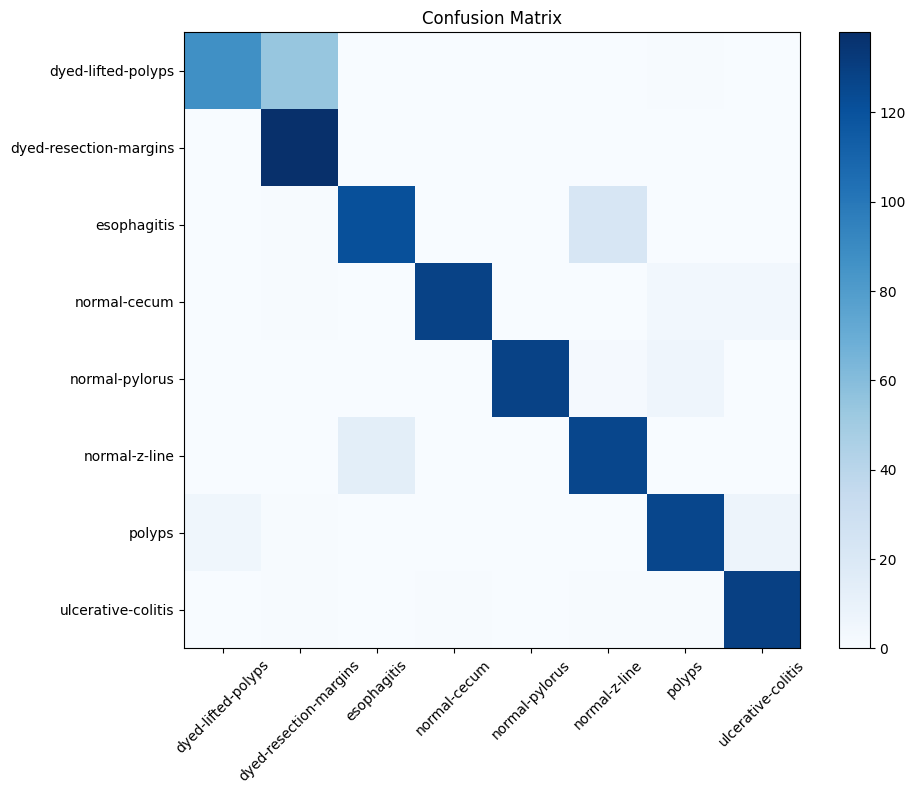

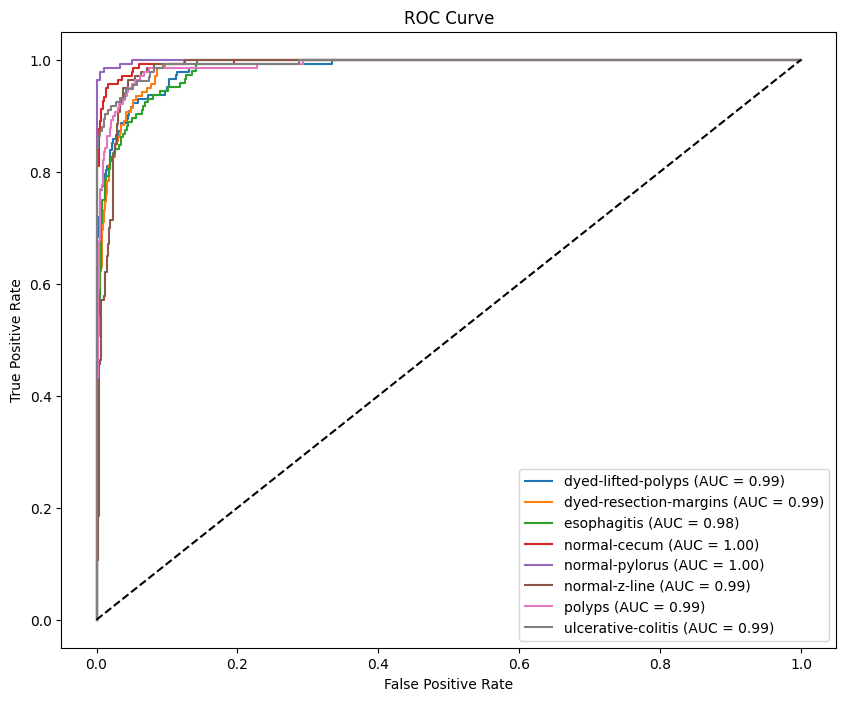

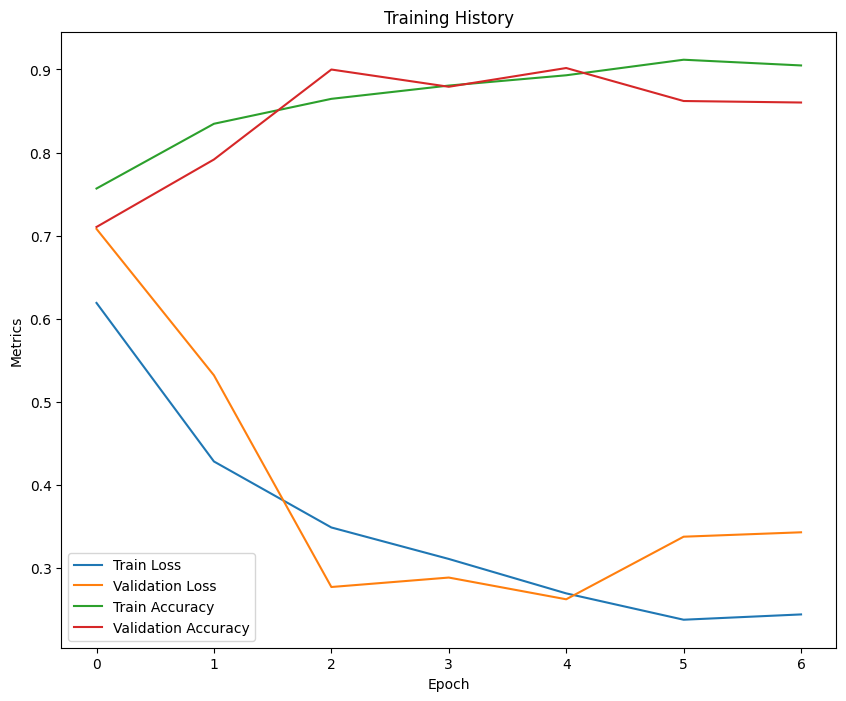

In [3]:
import os
import shutil
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.preprocessing import label_binarize

# Dataset path
DATASET_DIR = r"/kaggle/input/kvasir-dataset/kvasir-dataset"

# Split dataset into train, val, and test
SPLIT_RATIO = (0.7, 0.15, 0.15)
BASE_DIR = "split_data"

def split_dataset(dataset_dir, base_dir, split_ratio):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    for category in os.listdir(dataset_dir):
        category_path = os.path.join(dataset_dir, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)
            np.random.shuffle(images)
            train_end = int(split_ratio[0] * len(images))
            val_end = train_end + int(split_ratio[1] * len(images))

            splits = {
                "train": images[:train_end],
                "val": images[train_end:val_end],
                "test": images[val_end:]
            }

            for split, split_images in splits.items():
                split_dir = os.path.join(base_dir, split, category)
                os.makedirs(split_dir, exist_ok=True)
                for image in split_images:
                    shutil.copy(os.path.join(category_path, image), split_dir)

split_dataset(DATASET_DIR, BASE_DIR, SPLIT_RATIO)

# Transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize((358, 358)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((358, 358)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((358, 358)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Load data
datasets = {x: datasets.ImageFolder(os.path.join(BASE_DIR, x), transform=transform[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(datasets[x], batch_size=32, shuffle=(x == 'train')) for x in ['train', 'val', 'test']}

# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(datasets['train'].classes))
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=2):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Train and evaluate
num_epochs = 25
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
early_stopping = EarlyStopping(patience=2)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in tqdm(dataloaders['train']):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(datasets['train'])
    train_acc = correct_train / total_train

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(datasets['val'])
    val_acc = correct_val / total_val

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluate on test set
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=datasets['test'].classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(datasets['test'].classes)), datasets['test'].classes, rotation=45)
plt.yticks(np.arange(len(datasets['test'].classes)), datasets['test'].classes)
plt.show()

# ROC curve and AUC
binarized_labels = label_binarize(y_true, classes=list(range(len(datasets['test'].classes))))
y_scores = np.array(y_scores)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(datasets['test'].classes)):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(datasets['test'].classes)):
    plt.plot(fpr[i], tpr[i], label=f"{datasets['test'].classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Training history
plt.figure(figsize=(10, 8))
plt.plot(history['train_loss'], label="Train Loss")
plt.plot(history['val_loss'], label="Validation Loss")
plt.plot(history['train_acc'], label="Train Accuracy")
plt.plot(history['val_acc'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training History")
plt.show()


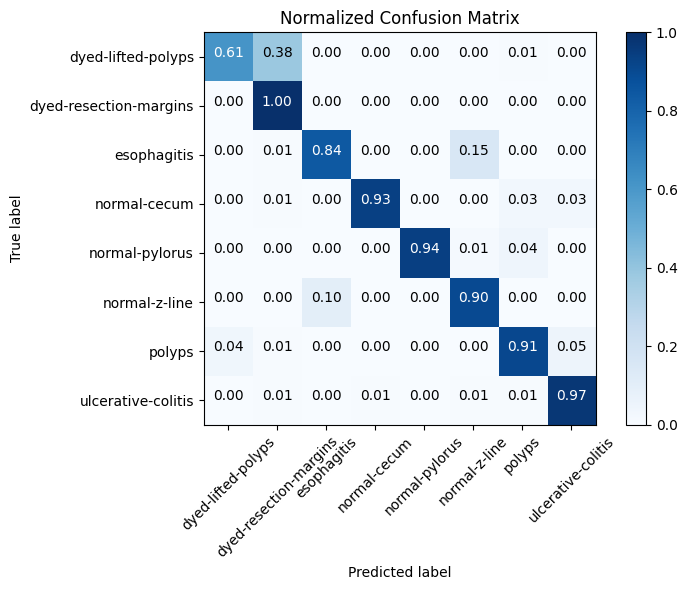

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_normalized_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add values to the plot
    thresh = cm_normalized.max() / 2
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, f"{cm_normalized[i, j]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming y_true, y_pred are defined and class_names is a list of class labels
plot_normalized_confusion_matrix(y_true, y_pred, class_names=datasets['test'].classes)


In [5]:
MODEL_PATH = "resnet18_kvasir.pth"
torch.save(model.state_dict(), os.path.join("/kaggle/working", MODEL_PATH))
print(f"Model saved to {MODEL_PATH}")


Model saved to resnet18_kvasir.pth
